# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import cvxpy as cp
import time
import collections
from typing import Dict
from typing import List
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import imp
import os
import pickle as pk
%matplotlib inline

import sys
sys.path.insert(0, '../../../src/')

import network_utils
import utils

# Helper functions

In [2]:
def reload():
    imp.reload(network_utils)
    imp.reload(utils)
    
def get_array_of_138(a):
    r = a
    if len(a) < 138:
        r = np.array(list(a) + [0 for i in range(138 - len(a))])
    return r

def get_matrix_stochastic(a):
    a = a / np.sum(a)
    return np.matrix(a)

# Body

In [3]:
triad_map, triad_list = network_utils.generate_all_possible_sparse_triads()
unique_triad_num = len(triad_list)

In [4]:
ch = []
for triad in triad_list:
    ch.append(network_utils.is_sparsely_cartwright_harary_balanced(triad))
ch = np.array(ch)

t = np.sum(ch)
print('{} C&H balance and {} non C&H balance.'.format(t, 138-t))



cluster = []
for triad in triad_list:
    cluster.append(network_utils.is_sparsely_clustering_balanced(triad))
cluster = np.array(cluster)

t = np.sum(cluster)
print('{} clustering balance and {} non clustering balance.'.format(t, 138-t))



# ranked_cluster = []
# for triad in triad_list:
#     ranked_cluster.append(network_utils.is(triad))
# ranked_cluster = np.array(ranked_cluster)

# t = np.sum(cluster)
# print('{} ranked clustering balance and {} non ranked cluster balance.'.format(t, 138-t))



transitives = []
for triad in triad_list:
    transitives.append(network_utils.is_sparsely_transitive_balanced(triad))
transitives = np.array(transitives)

t = np.sum(transitives)
print('{} transitive and {} nontransitive.'.format(t, 138-t))

24 C&H balance and 114 non C&H balance.
44 clustering balance and 94 non clustering balance.
93 transitive and 45 nontransitive.


### Convex optimization problem

In [5]:
loaded_d = utils.load_it('/home/omid/Downloads/DT/cvx_data_bitcoin_otc_separated.pk')
obs = loaded_d['obs']
T = loaded_d['T']

obs_mat = []
for o in obs:
    obs_mat.append(np.matrix(o))
    
obs_normalized = []
for o in obs:
    obs_normalized.append(get_matrix_stochastic(o))

In [8]:
# l = l - 1  # one less than actual value
r = obs_normalized

In [9]:
l = len(T)    # 66
test_numbers = 10

In [10]:
l

66

It took :29.0 mins.
Errors: 0.0467 +- 0.0
[0.06342498961234225, 0.040907988967165486, 0.013612269441065483, 0.020647515457058223, 0.058024421310294075, 0.07493948729970318, 0.05003351713435574, 0.05935827324460509, 0.040214671549611246, 0.045454335272957155]


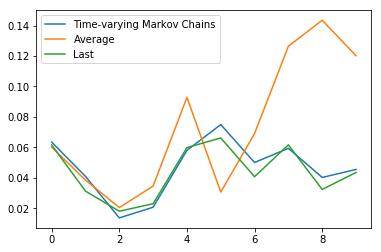

In [15]:
start_time = time.time()

n = 138
eps = 0.01
# lam1 = 0.5

errs = []
for test_number in np.arange(test_numbers, 0, -1):

    P = [cp.Variable(n, n) for _ in range(l - test_number - 1)]

    term1 = 0
    for i in range(1, l - test_number - 1):
        term1 += cp.norm2(P[i] - P[i - 1])

#     term2 = 0
#     for i in range(1, l - test_number - 1):
#         term2 += cp.norm1(P[i] - P[i - 1])

    objective = cp.Minimize(term1)  # + term2 * lam1)

    # Constraints.
    constraints = []
    for i in range(l - test_number - 1):
        constraints += (
            [0 < P[i],
             P[i] <= 1,
             P[i] * np.ones(n) == np.ones(n),
             r[i] * P[i] == r[i + 1],
#              r[i + 1] * P[i] == r[i + 1]])
             cp.norm2(r[i + 1] * P[i] - r[i + 1]) < eps])

    # Problem.
    prob = cp.Problem(objective, constraints)

    # Solving the problem.
    res = prob.solve(cp.MOSEK)
    err = np.linalg.norm(r[l - test_number] - (r[l - test_number - 1] * P[l - test_number - 2].value), 2)
    errs.append(err)

duration = time.time() - start_time
print('It took :{} mins.'.format(round(duration/60, 2)))
print('Errors: {} +- {}'.format(round(np.mean(errs), 4), round(np.std(errs)), 6))
print(errs)

# Baselines.
mean_errs = []
for test_number in np.arange(test_numbers, 0, -1):
    mean_err = np.linalg.norm(r[l - test_number] - np.mean(r[:l - test_number - 1], axis=0)[0], 2)
    mean_errs.append(mean_err)
last_errs = []
for test_number in np.arange(test_numbers, 0, -1):
    last_err = np.linalg.norm(r[l - test_number] - r[l - test_number - 1], 2)
    last_errs.append(last_err)
# rnd_errs = []
# for test_number in np.arange(test_numbers, 0, -1):
#     rnd_err = np.linalg.norm(r[l - test_number] - (1/138) * np.ones(138), 2)
#     rnd_errs.append(rnd_err)

plt.plot(errs)
# plt.plot(rnd_errs)
plt.plot(mean_errs)
plt.plot(last_errs)
plt.legend(['Time-varying Markov Chains', 'Average', 'Last']);
# plt.legend(['Time-varying Markov Chains', 'Random', 'Average', 'Last']);

In [19]:
# # Saving the estimated transition matrices (P).
# estimated_matrices = []
# for i in range(len(P)):
#     estimated_matrices.append(P[i].value)
# with open('estimated_matrices_otc.pk', 'wb') as f:
#     pk.dump(estimated_matrices, f)

In [5]:
# # Loading.
# with open('estimated_matrices_otc.pk', 'rb') as f:
#     estimated_matrices = pk.load(f)

In [16]:
errs

[0.06342498961234225,
 0.040907988967165486,
 0.013612269441065483,
 0.020647515457058223,
 0.058024421310294075,
 0.07493948729970318,
 0.05003351713435574,
 0.05935827324460509,
 0.040214671549611246,
 0.045454335272957155]

In [17]:
mean_errs

[0.06016850046110977,
 0.038444897325309715,
 0.020426802153895456,
 0.0345312317592556,
 0.09281941577864693,
 0.03060403758832463,
 0.06910275575807862,
 0.1264610357776136,
 0.14352778093936164,
 0.12018484032339813]

In [18]:
last_errs

[0.06155312345321347,
 0.03123064178765042,
 0.01801369897541606,
 0.022936391417641977,
 0.059814895336017346,
 0.06616115857038168,
 0.040697586027385,
 0.061617753336263285,
 0.03232466525787866,
 0.04347395380242551]

# Predicting only the last one by timeseries forecasting

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [39]:
start_time = time.time()


forecasted_T = np.zeros((138, 138))
for i in range(138):
    print(i)
    for j in range(138):
        train_ts = []
        for index in range(len(P)):
            train_ts.append(P[index].value[i, j])
        if len(np.unique(train_ts)) == 1:
            prediction = train_ts[0]
        else:
            model = ARIMA(train_ts, order=(1, 1, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=1)[0][0]  # just the prediction value.    
        forecasted_T[i, j] = prediction


duration = time.time() - start_time
print('It took :{} mins.'.format(round(duration/60, 2)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
It took :13.01 mins.


In [42]:
np.linalg.norm(r[l - test_number] - (r[l - test_number - 1] * forecasted_T), 2)

0.04379110832883748

In [48]:
errs[-1]

0.045454335272957155

In [49]:
last_errs[-1]

0.04347395380242551

In [50]:
mean_errs[-1]

0.12018484032339813

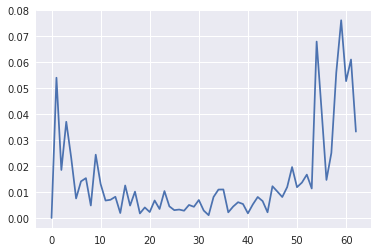

In [53]:
sns.set(rc={'figure.figsize': (6, 4)})
diff = []
for i in range(1, l-2):
    diff.append(np.linalg.norm(P[i].value - P[i-1].value))
plt.plot(diff);

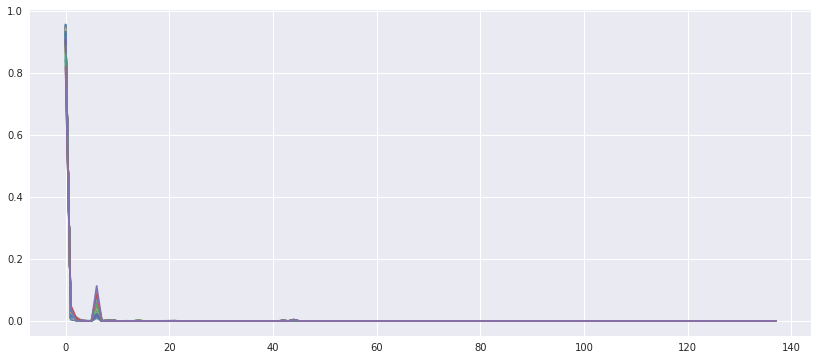

In [21]:
sns.set(rc={'figure.figsize': (14, 6)})
legends = []
for i, transition_matrix in enumerate(P):
    st_dist = network_utils.get_stationary_distribution(np.asarray(transition_matrix.value))
    plt.plot(st_dist)
#     legends.append(i)
# plt.legend(legends)

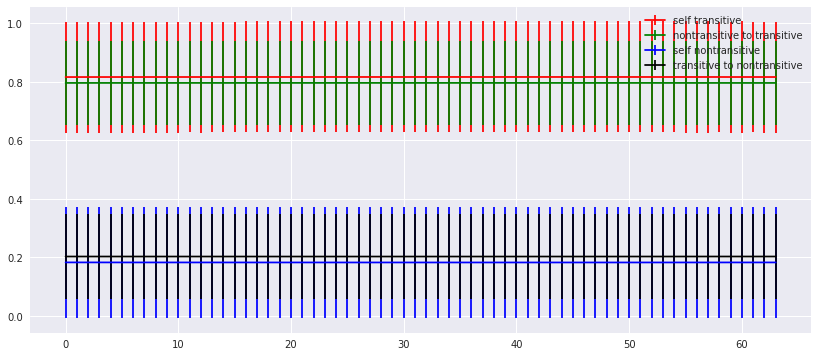

In [22]:
self_transitive_means = []
self_nontransitive_means = []
nontransitive_to_transitive_means = []
transitive_to_nontransitive_means = []
self_transitive_stds = []
self_nontransitive_stds = []
nontransitive_to_transitive_stds = []
transitive_to_nontransitive_stds = []

for matrix in P:
    trans_matrix = matrix.value
    
    probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
    self_transitive_means.append(np.mean(probs))
    self_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
    nontransitive_to_transitive_means.append(np.mean(probs))
    nontransitive_to_transitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
    transitive_to_nontransitive_means.append(np.mean(probs))
    transitive_to_nontransitive_stds.append(np.std(probs))

    probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
    self_nontransitive_means.append(np.mean(probs))
    self_nontransitive_stds.append(np.std(probs))
    

plt.errorbar(x=np.arange(l-2), y=self_transitive_means, yerr=self_transitive_stds, fmt='r')
plt.errorbar(x=np.arange(l-2), y=nontransitive_to_transitive_means, yerr=nontransitive_to_transitive_stds, fmt='g')
plt.errorbar(x=np.arange(l-2), y=self_nontransitive_means, yerr=self_nontransitive_stds, fmt='b')
plt.errorbar(x=np.arange(l-2), y=transitive_to_nontransitive_means, yerr=transitive_to_nontransitive_stds, fmt='k')
plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);


# plt.errorbar(x=np.arange(39), y=self_transitive_means) #, yerr=self_transitive_stds)
# plt.errorbar(x=np.arange(39), y=nontransitive_to_transitive_means) #, yerr=nontransitive_to_transitive_stds)
# plt.errorbar(x=np.arange(39), y=self_nontransitive_means) #, yerr=self_nontransitive_stds)
# plt.errorbar(x=np.arange(39), y=transitive_to_nontransitive_means) #, yerr=transitive_to_nontransitive_stds)
# plt.legend(['self transitive', 'nontransitive to transitive', 'self nontransitive', 'transitive to nontransitive']);

In [7]:
trans_matrix = P[-1].value
# trans_matrix= estimated_matrices[-1]

Transition probability of "transitive to self": 0.82 +- 0.19
Transition probability of "not transitive to transitive": 0.8 +- 0.14
Transition probability of "not transitive to self": 0.2 +- 0.14
Transition probability of "transitive to not transitive": 0.18 +- 0.19


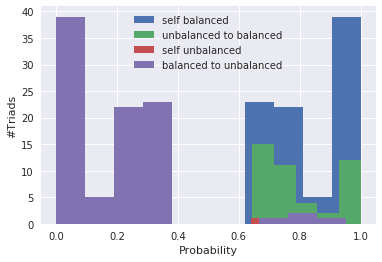

In [20]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.legend(['self balanced', 'unbalanced to balanced', 'self unbalanced', 'balanced to unbalanced'])
plt.xlabel('Probability')
plt.ylabel('#Triads');

Transition probability of "C&H balance to self": 0.87 +- 0.26
Transition probability of "not C&H balance to C&H balance": 0.53 +- 0.32
Transition probability of "not C&H balance to self": 0.47 +- 0.32
Transition probability of "C&H balance to not C&H balance": 0.13 +- 0.26


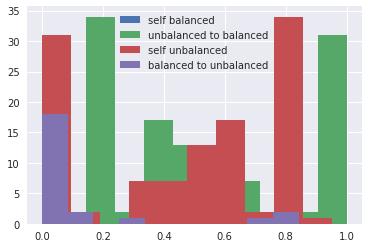

In [21]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[ch, :][:, ch], axis=1)
plt.hist(probs)
print('Transition probability of "C&H balance to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ch], axis=1)
plt.hist(probs)
print('Transition probability of "not C&H balance to C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~ch, :][:, ~ch], axis=1)
plt.hist(probs)
print('Transition probability of "not C&H balance to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[ch, :][:, ~ch], axis=1)
plt.hist(probs)
print('Transition probability of "C&H balance to not C&H balance": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.legend(['self balanced', 'unbalanced to balanced', 'self unbalanced', 'balanced to unbalanced']);

Transition probability of "clustering to self": 0.93 +- 0.17
Transition probability of "not clustering to clustering": 0.78 +- 0.21
Transition probability of "not clustering to self": 0.22 +- 0.21
Transition probability of "clustering to not clustering": 0.07 +- 0.17


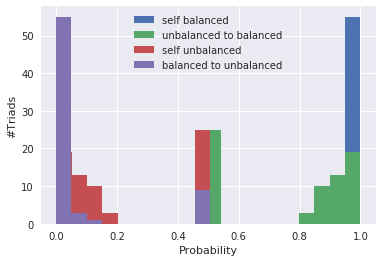

In [26]:
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[cluster, :][:, cluster], axis=1)
plt.hist(probs)
print('Transition probability of "clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, cluster], axis=1)
plt.hist(probs)
print('Transition probability of "not clustering to clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~cluster, :][:, ~cluster], axis=1)
plt.hist(probs)
print('Transition probability of "not clustering to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[cluster, :][:, ~cluster], axis=1)
plt.hist(probs)
print('Transition probability of "clustering to not clustering": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.legend(['self balanced', 'unbalanced to balanced', 'self unbalanced', 'balanced to unbalanced'])
plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.savefig('country_clustering_transitionprobabilities.png');

# Specific triads transitions in different transition probability matrices

In [12]:
def print_those(from_triad, to_triad):
    probs = []
    for l in range(len(T)):
        probs.append(
            T[l][from_triad, to_triad])
    print('{} +- {}'.format(np.mean(probs), np.std(probs)))

    probs = []
    for l in range(len(estimated_matrices)):
        probs.append(
            estimated_matrices[l][from_triad, to_triad])
    print('{} +- {}\n'.format(np.mean(probs), np.std(probs)))

In [13]:
# transitivity balanced
print_those(from_triad=8, to_triad=22)

#classically balanced
print_those(from_triad=18, to_triad=33)
print_those(from_triad=15, to_triad=26)
print_those(from_triad=11, to_triad=37)

0.0 +- 0.0
2.4445527858231453e-06 +- 2.69676245602496e-06

0.0 +- 0.0
1.0180007138411928e-06 +- 1.464592989360827e-06

0.0 +- 0.0
1.0806940904242441e-06 +- 1.4659336233488619e-06

0.0 +- 0.0
9.842914104820244e-07 +- 1.1086378804604973e-06



In [15]:
np.where(estimated_matrices[0] > 0.99)

(array([ 3,  4,  5,  7, 11, 12, 14, 16, 20, 21, 36, 42, 44, 45, 50, 51, 63]),
 array([0, 0, 0, 6, 0, 0, 0, 1, 0, 6, 6, 0, 0, 6, 1, 2, 1]))

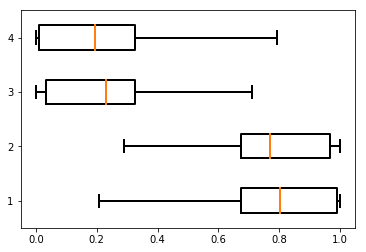

In [22]:
# reload()
# utils.plot_box_plot_for_transitions(
#     estimated_matrices[-1], transitives, 'Bitcoin_OTC_transitivity', 'Bitcoin OTC')

reload()
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], transitives, False, 'Bitcoin_OTC_transitivity')

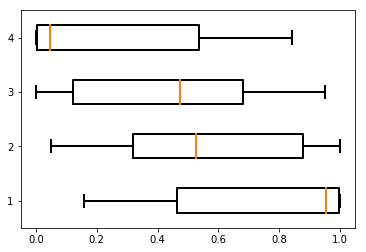

In [23]:
# reload()
# utils.plot_box_plot_for_transitions(estimated_matrices[-1], cluster, 'Bitcoin_OTC_clustering', 'Bitcoin OTC')

reload()
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], cluster, False, 'Bitcoin_OTC_clustering')

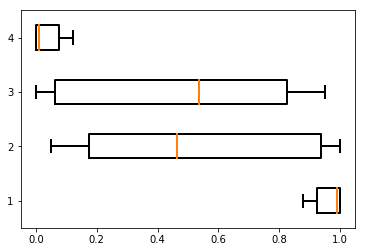

In [28]:
reload()
utils.plot_box_plot_for_transitions(
    estimated_matrices[-1], ch, False, 'Bitcoin_OTC_classical')

In [6]:
trans_matrix = estimated_matrices[-1]

Transition probability of "transitive to self": 0.82 +- 0.19
Transition probability of "not transitive to transitive": 0.8 +- 0.14
Transition probability of "transitive to not transitive": 0.18 +- 0.19
Transition probability of "not transitive to self": 0.2 +- 0.14


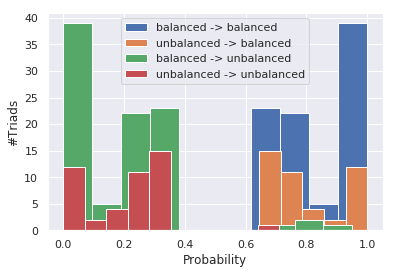

In [7]:
# trans_matrix = estimated_matrices[-1]


sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
plt.hist(probs)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend(['balanced -> balanced', 'unbalanced -> balanced', 'balanced -> unbalanced', 'unbalanced -> unbalanced'])
# plt.title('(a)', weight='bold')
plt.savefig('BitcoinOTC_transitivity_transitionprobabilities.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Transition probability of "transitive to self": 0.82 +- 0.19
Transition probability of "not transitive to transitive": 0.8 +- 0.14
Transition probability of "transitive to not transitive": 0.18 +- 0.19
Transition probability of "not transitive to self": 0.2 +- 0.14


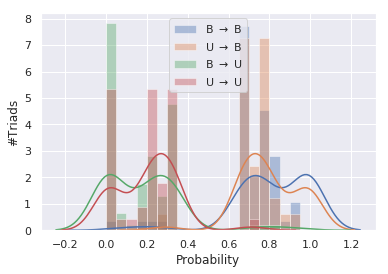

In [12]:
bins = np.arange(0, 1, 0.05)
# plt.figure(facecolor='w')
sns.set(rc={'figure.figsize': (6, 4)})
probs = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
sns.distplot(probs, bins=bins)
print('Transition probability of "transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
sns.distplot(probs, bins=bins)
print('Transition probability of "not transitive to transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
sns.distplot(probs, bins=bins)
print('Transition probability of "transitive to not transitive": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

probs = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)
sns.distplot(probs, bins=bins)
print('Transition probability of "not transitive to self": {} +- {}'.format(
        round(np.mean(probs), 2), round(np.std(probs), 2)))

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
# plt.savefig('BitcoinOTC_transitivity_transitionprobabilities_kde.pdf');

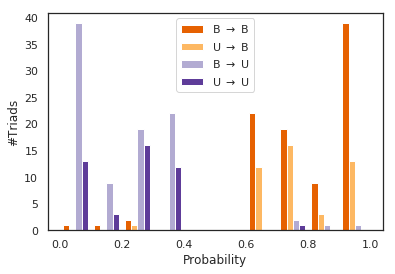

In [43]:
sns.set_style('white', rc={'figure.figsize': (6, 4)})
probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

colors = ['#e66101', '#fdb863', '#b2abd2', '#5e3c99']
plt.hist([probs1, probs2, probs3, probs4], color=colors)

plt.xlabel('Probability')
plt.ylabel('#Triads');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('BitcoinOTC_transitivity_transitionprobabilities_binbeside.pdf');

In [90]:
def set_the_hatch(bars, hatch):
    for patch in bars.patches:
        if not patch.get_hatch():
            patch.set_hatch(hatch)

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


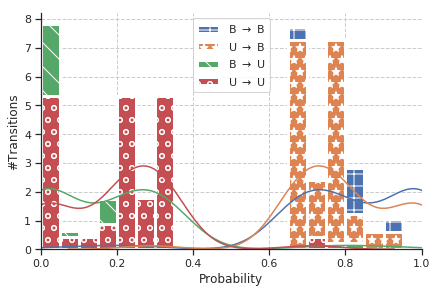

In [96]:
sns.set_style('white', rc={'figure.figsize': (6, 4)})
ax = plt.gca()
bins = np.arange(0, 1, 0.05)
alpha = 1

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

bars = sns.distplot(probs1, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[1])
    
bars = sns.distplot(probs2, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[4])

bars = sns.distplot(probs3, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[3])

bars = sns.distplot(probs4, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
set_the_hatch(bars, hatches[5])

ax.set_xlim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.grid(b=True, which='major', linestyle='--')
ax.xaxis.grid(b=True, which='minor', linestyle=':')
ax.yaxis.grid(b=True, which='major', linestyle='--')

plt.tight_layout()

plt.xlabel('Probability')
plt.ylabel('#Transitions');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('BitcoinOTC_transitivity_transitionprobabilities_kde2.pdf');

/home/omid/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


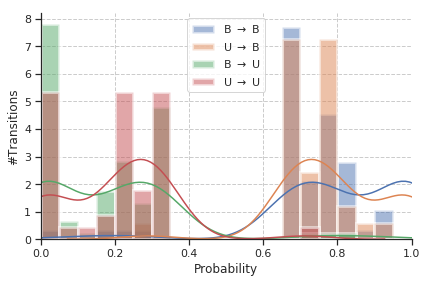

In [99]:
sns.set_style('white', rc={'figure.figsize': (6, 4)})
ax = plt.gca()
bins = np.arange(0, 1, 0.05)
alpha = 0.5

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

probs1 = np.sum(trans_matrix[transitives, :][:, transitives], axis=1)
probs2 = np.sum(trans_matrix[~transitives, :][:, transitives], axis=1)
probs3 = np.sum(trans_matrix[transitives, :][:, ~transitives], axis=1)
probs4 = np.sum(trans_matrix[~transitives, :][:, ~transitives], axis=1)

sns.distplot(probs1, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs2, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs3, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})
sns.distplot(probs4, bins=bins, norm_hist=False, hist_kws={"linewidth": 3, "alpha": alpha})

ax.set_xlim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.grid(b=True, which='major', linestyle='--')
ax.xaxis.grid(b=True, which='minor', linestyle=':')
ax.yaxis.grid(b=True, which='major', linestyle='--')

plt.tight_layout(pad=1.5)

plt.xlabel('Probability')
plt.ylabel('#Transitions');
plt.legend([r'B $\rightarrow$ B', r'U $\rightarrow$ B', r'B $\rightarrow$ U', r'U $\rightarrow$ U'], loc='upper center');
plt.savefig('BitcoinOTC_transitivity_transitionprobabilities_kde.pdf');